In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import sys
import os

from ExptTrace import ExptTrace
from FileManager import FileManager
from misc import rcsetup

rcsetup()

sys.path.append("../")

from kernels import GaussianKernel, LaplaceKernel
from utils import ensure_torch, ensure_numpy
from eigenlearning import eigenlearning
from feature_decomp import Monomial

In [2]:
import matplotlib.colors as mcolors

colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]

def lighten(color, amount=0.5):
    rgb = mcolors.to_rgb(mcolors.XKCD_COLORS.get(color, color))
    if amount >= 0:
        new_rgb = tuple(c + (1 - c) * amount for c in rgb)
    else:
        new_rgb = tuple(c * (1 + amount) for c in rgb)
    # Clip values to [0, 1]
    new_rgb = tuple(min(max(x, 0), 1) for x in new_rgb)
    return new_rgb

# Real targets (superclassed)

In [36]:
expt_id = 6
EXPT_NAME = "learning-curves-debug"
N_SAMPLES = 25_000
P_MODES = 50_000
DATA_DIM = 200

# Defaults
DATASET = "gaussian"
DATA_EIGVAL_EXP = 1.0
ZCA_STRENGTH = 0
GRAYSCALE = False
M_GRF = 99_000
TARGET = "powerlaws"
source_exps = [1.15]
KERNEL_TYPE = GaussianKernel
KERNEL_WIDTH = 10
RIDGE = 1e-3

if expt_id == 1:
    DATASET = "cifar10"
    TARGET = "vehicle"
if expt_id == 2:
    DATASET = "cifar10"
    TARGET = "domesticated"
if expt_id == 3:
    DATASET = "svhn"
    ZCA_STRENGTH = 1e-2
    TARGET = "evenodd"
    GRAYSCALE = True
if expt_id == 4:
    DATASET = "svhn"
    ZCA_STRENGTH = 1e-2
    TARGET = "loops"
    GRAYSCALE = True
if expt_id == 5:
    KERNEL_TYPE = LaplaceKernel
    ZCA_STRENGTH = 5e-3
    DATASET = "cifar10"
    TARGET = "vehicle"
    M_GRF = 40_000
if expt_id == 6:
    KERNEL_TYPE = LaplaceKernel
    ZCA_STRENGTH = 5e-3
    DATASET = "cifar10"
    TARGET = "domesticated"
    M_GRF = 30_000
if expt_id == 7:
    KERNEL_TYPE = LaplaceKernel
    ZCA_STRENGTH = 1e-2
    GRAYSCALE = True
    DATASET = "svhn"
    TARGET = "evenodd"
if expt_id == 8:
    KERNEL_TYPE = LaplaceKernel
    ZCA_STRENGTH = 1e-2
    GRAYSCALE = True
    DATASET = "svhn"
    TARGET = "loops"
if expt_id == 9:
    KERNEL_TYPE = LaplaceKernel
    DATASET = "gaussian"
    DATA_EIGVAL_EXP = 1.6
    TARGET = "powerlaws"
if expt_id == 10:
    KERNEL_TYPE = LaplaceKernel
    ZCA_STRENGTH = 1e-2
    M_GRF = 50_000
    DATASET = "cifar10"
    TARGET = "powerlaws"

datapath = os.getenv("DATASETPATH")
exptpath = os.getenv("EXPTPATH")
if datapath is None:
    raise ValueError("must set $DATASETPATH environment variable")
if exptpath is None:
    raise ValueError("must set $EXPTPATH environment variable")
fp = f"{KERNEL_TYPE.__name__}-kw:{KERNEL_WIDTH}-target:{TARGET}"
if DATASET == "gaussian":
    fp += f"-data:{DATA_DIM}:{DATA_EIGVAL_EXP}"
else:
    fp += f"-zca:{ZCA_STRENGTH}"
expt_dir = os.path.join(exptpath, "phlab", EXPT_NAME, DATASET, fp)

if not os.path.exists(expt_dir):
    assert False, f"Experiment directory {expt_dir} does not exist"
expt_fm = FileManager(expt_dir)

result = expt_fm.load("result.pickle")
monomials = result["monomials"]
d_eff = result["d_eff"]
print(f"d_eff = {d_eff:.2f}")
ridge = result["ridge"]
et_yhat = ExptTrace.deserialize(result["y_hat"])

# emp_eigvals = result["emp_eigvals"]
hehe_eigvals = result["th_eigvals"]
# iso_eigvals = result["iso_eigvals"]

targets = expt_fm.load("targets.pickle")
target = list(targets.keys())[0]

grf_results = expt_fm.load("grf.pickle")
coeffs = ExptTrace.deserialize(grf_results["coeffs"])
coeffs = coeffs[target]
residual = ExptTrace.deserialize(grf_results["residual"])
residual = residual[target]

# emp_eigvecs = expt_fm.load("emp_eigvecs.npy")
# H = expt_fm.load("H.npy")
H_norm = expt_fm.load("H_norm.npy") # np.linalg.norm(H, axis=0)
print(H_norm.min(), H_norm.max())
print(f"avg H norm {H_norm.mean():.3f}, std {(H_norm-H_norm.mean()).std():.3f}")

ntest = result["n_test"]
ntrains = et_yhat.get_axis("ntrain")
trials = et_yhat.get_axis("trial")

d_eff = 38.15
0.60419995 9.3199005
avg H norm 1.207, std 0.244


0.6324287544075393
0.22792559753956057


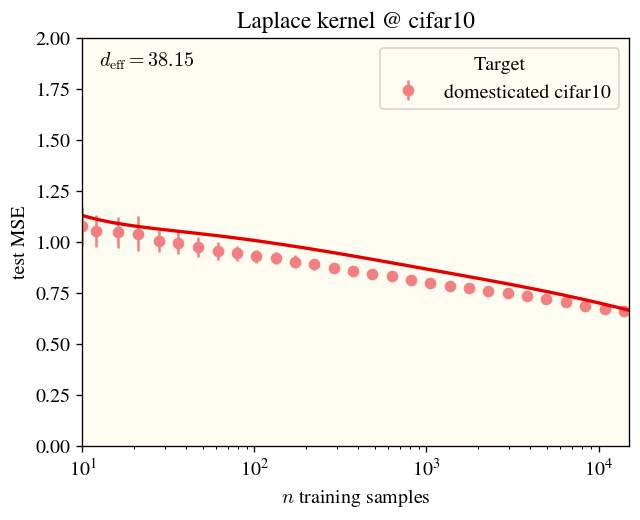

In [37]:
from eigenlearning import compute_learnabilities, learning_curve
from data import get_powerlaw

fig, ax = plt.subplots(figsize=(5.5, 4.5))

xmin, xmax = 10, 15e3
TrK = 1.0
ntrains_dense = np.logspace(np.log10(xmin), np.log10(xmax), 200)
hehe_ridge = ridge + max(0, TrK - hehe_eigvals.sum())
learnabilities, kappa = compute_learnabilities(ntrains_dense, hehe_eigvals, hehe_ridge)

# coeffs_true = np.sqrt(ensure_numpy(get_powerlaw(P_MODES, target, offset=6)))
# print(np.linalg.norm(coeffs_true), np.linalg.norm(coeffs))
print(np.linalg.norm(coeffs)**2)

for i, target in enumerate([target]):
    ystar = targets[target][:N_SAMPLES]
    yhat = et_yhat[:, :, target].squeeze()
    mse = ((yhat - ystar[-ntest:])**2).mean(axis=-1)
    lrn_curve_emp, lrn_curve_emp_std = mse.mean(axis=0), mse.std(axis=0)
    label = f"{target} {DATASET}"
    ax.errorbar(ntrains, lrn_curve_emp, yerr=lrn_curve_emp_std, color=lighten(colors[i], 0.5),
                ls='none', marker='o', zorder=-4, label=label)

    coeffs_normed = coeffs * H_norm
    noise_var = np.linalg.norm(residual)**2
    print(noise_var)
    lrn_curve_hehe = learning_curve(ntrains_dense, learnabilities, coeffs_normed, noise_var=noise_var)
    ax.plot(ntrains_dense, lrn_curve_hehe, color=colors[i], lw=2)

kname = "Gaussian" if KERNEL_TYPE == GaussianKernel else "Laplace"
ax.set_title(f"{kname} kernel @ {DATASET}", fontsize=14)

ax.text(0.03, 0.97, f"$d_\\mathrm{{eff}} = {d_eff:.2f}$", ha="left", va="top", transform=ax.transAxes)
ax.set_xlabel(f"$n$ training samples")
ax.set_ylabel("test MSE")

ax.set_xscale("log")
ax.set_xlim(xmin, xmax)
ax.set_ylim(0, 2)
# ax.set_ylim(1e-2, 2)
# ax.set_yscale("log")
ax.legend(title="Target", ncol=2)
plt.tight_layout()
plt.show()

In [33]:
coeffs_normed = coeffs * H_norm
print((coeffs_normed[:100]**2).round(4))
# [5.94875004e-05 7.84320974e-02 1.11251995e-01 1.18377775e-02
#  5.06454466e-02 5.20491244e-02 1.54220858e-04 2.77191091e-03
#  2.51772044e-02 1.00432126e-02]

[1.000e-04 7.840e-02 1.113e-01 1.180e-02 5.060e-02 5.200e-02 2.000e-04
 2.800e-03 2.520e-02 1.000e-02 0.000e+00 1.200e-03 1.300e-03 0.000e+00
 1.000e-04 0.000e+00 3.000e-03 1.120e-02 1.000e-04 4.400e-03 0.000e+00
 0.000e+00 0.000e+00 1.000e-04 2.000e-04 3.000e-04 7.000e-04 2.500e-03
 1.000e-04 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e-04 0.000e+00
 3.000e-04 0.000e+00 0.000e+00 3.000e-04 9.000e-04 5.000e-04 0.000e+00
 1.000e-04 0.000e+00 0.000e+00 0.000e+00 1.000e-04 0.000e+00 1.000e-04
 0.000e+00 0.000e+00 1.000e-04 4.500e-03 3.000e-04 5.000e-04 6.500e-03
 4.100e-03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e-04 2.000e-04
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e-04 1.000e-04 0.000e+00
 0.000e+00 0.000e+00 1.000e-03 3.000e-04 1.000e-04 2.000e-04 3.000e-04
 1.000e-04 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000

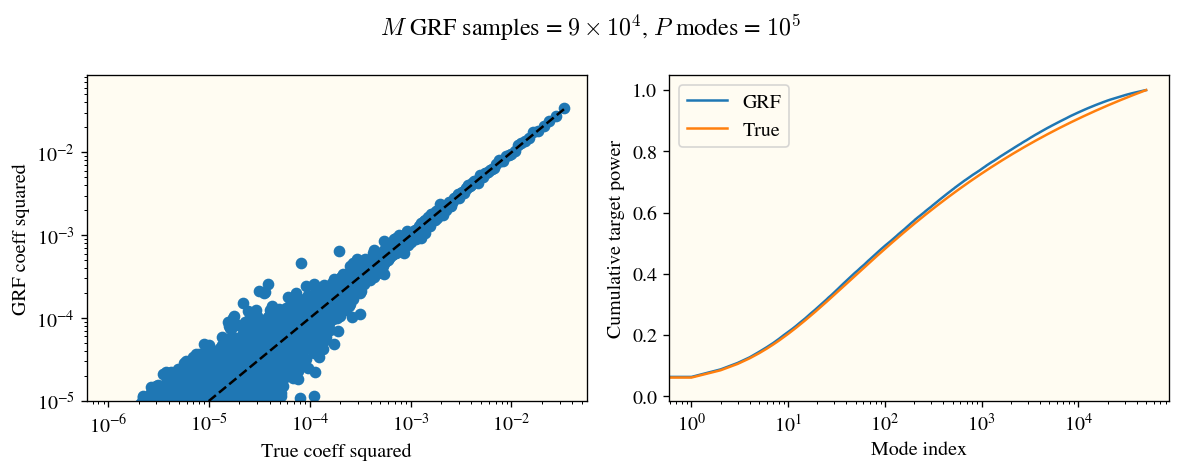

In [5]:
coeffs_normed = coeffs * H_norm
fig, axes = plt.subplots(ncols=2, figsize=(10,4))

ax = axes[0]
ax.scatter(coeffs_true**2, coeffs_normed**2)
ax.plot(coeffs_true**2, coeffs_true**2, 'k--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-5, .085)
ax.set_xlabel('True coeff squared')
ax.set_ylabel('GRF coeff squared')

ax = axes[1]
ax.plot(np.cumsum(coeffs_normed**2)/np.sum(coeffs_normed**2), label='GRF')
ax.plot(np.cumsum(coeffs_true**2)/np.sum(coeffs_true**2), label='True')
ax.set_xscale('log')
ax.set_xlabel('Mode index')
ax.set_ylabel('Cumulative target power')
ax.legend()

plt.suptitle(f"$M$ GRF samples = $9\\times10^4$, $P$ modes = $10^5$")
plt.tight_layout()
plt.show()

# Powerlaw data

In [3]:
expt_id = 2
EXPT_NAME = "hehe-eigenlearning"
KERNEL_WIDTH = 10
N_SAMPLES = 25_000
P_MODES = 25_000
DATA_DIM = 200
TARGET = "powerlaws"

if expt_id == 1:
    DATASET = "gaussian"
    KERNEL_TYPE = GaussianKernel
elif expt_id == 2:
    DATASET = "gaussian"
    KERNEL_TYPE = LaplaceKernel
elif expt_id == 3:
    DATASET = "cifar10"
    KERNEL_TYPE = GaussianKernel
elif expt_id == 4:
    DATASET = "cifar10"
    KERNEL_TYPE = LaplaceKernel

if KERNEL_TYPE == GaussianKernel:
    DATA_EIGVAL_EXP = 3.0   # d_eff = 7
    ZCA_STRENGTH = 0        # d_eff = 7
if KERNEL_TYPE == LaplaceKernel:
    DATA_EIGVAL_EXP = 1.6   # d_eff = 27
    ZCA_STRENGTH = 1e-2     # d_eff = 26

datapath = os.getenv("DATASETPATH")
exptpath = os.getenv("EXPTPATH")
if datapath is None:
    raise ValueError("must set $DATASETPATH environment variable")
if exptpath is None:
    raise ValueError("must set $EXPTPATH environment variable")
fp = f"{KERNEL_TYPE.__name__}-kw:{KERNEL_WIDTH}-target:{TARGET}"
if DATASET == "gaussian":
    fp += f"-data:{DATA_DIM}:{DATA_EIGVAL_EXP}"
else:
    fp += f"-zca:{ZCA_STRENGTH}"
expt_dir = os.path.join(exptpath, "phlab", EXPT_NAME, DATASET, fp)

if not os.path.exists(expt_dir):
    assert False
expt_fm = FileManager(expt_dir)

In [31]:
result = expt_fm.load("result.pickle")
monomials = result["monomials"]
d_eff = result["d_eff"]
print(f"d_eff = {d_eff:.2f}")
ridge = result["ridge"]
et_yhat = ExptTrace.deserialize(result["y_hat"])

emp_eigvals = result["emp_eigvals"]
hehe_eigvals = result["th_eigvals"]
iso_eigvals = result["iso_eigvals"]

targets = expt_fm.load("targets.pickle")
source_exps = np.array(list(targets.keys()))

emp_eigvecs = expt_fm.load("emp_eigvecs.npy")
H = expt_fm.load("H.npy")

ntest = result["n_test"]
ntrains = et_yhat.get_axis("ntrain")
trials = et_yhat.get_axis("trial")

d_eff = 26.57


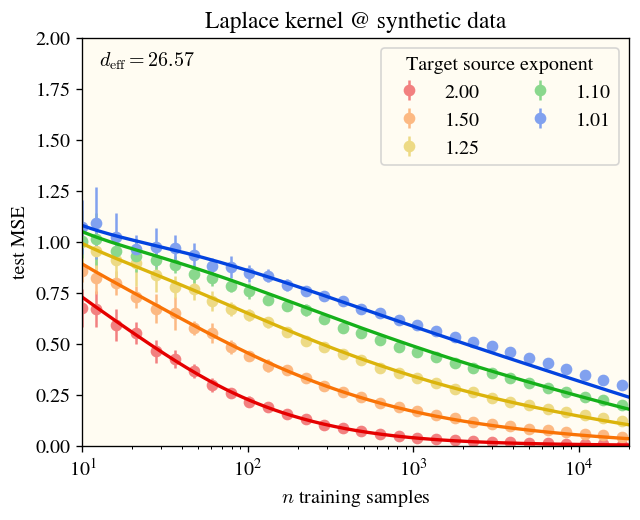

In [33]:
from data import get_powerlaw

fig, ax = plt.subplots(figsize=(5.5, 4.5))

xmin, xmax = 10, 2e4
TrK = 1.0
use_hehe_coeffs = True
use_ots_correction = False
ntrains_dense = np.logspace(np.log10(xmin), np.log10(xmax), 200)
for i, source_exp in enumerate(source_exps[::-1]):
    ystar = targets[source_exp]
    yhat = et_yhat[:, :, source_exp].squeeze()
    mse = ((yhat - ystar[-ntest:])**2).mean(axis=-1)
    lrn_curve_emp, lrn_curve_emp_std = mse.mean(axis=0), mse.std(axis=0)
    ax.errorbar(ntrains, lrn_curve_emp, yerr=lrn_curve_emp_std, color=lighten(colors[i], 0.5),
                ls='none', marker='o', zorder=-4, label=f"{source_exp:.2f}")

    eigvals = hehe_eigvals[:N_SAMPLES]
    if use_hehe_coeffs:
        coeffs = ensure_numpy(torch.sqrt(get_powerlaw(P_MODES, source_exp, offset=6)))
    else:
        coeffs = emp_eigvecs.T @ ystar
    coeffs /= np.linalg.norm(coeffs)
    hehe_ridge = ridge + max(0, TrK - eigvals.sum())
    el_hehe = lambda n: eigenlearning(n, eigvals, coeffs, ridge=hehe_ridge)
    mse_el_hehe = np.array([el_hehe(n)["test_mse"] for n in ntrains_dense])
    if use_ots_correction:
        train_mse = np.array([el_hehe(n)["train_mse"] for n in ntrains_dense])
        mse_el_hehe = (N_SAMPLES*mse_el_hehe - train_mse*ntrains_dense) / (N_SAMPLES - ntrains_dense)
    ax.plot(ntrains_dense, mse_el_hehe, color=colors[i], lw=2)

kname = "Gaussian" if KERNEL_TYPE == GaussianKernel else "Laplace"
dataname = "CIFAR10" if DATASET == "cifar10" else "synthetic data"
omniscient = "" if use_hehe_coeffs else " (omniscient empirical coeffs)"
ax.set_title(f"{kname} kernel @ {dataname}{omniscient}", fontsize=14)

ax.text(0.03, 0.97, f"$d_\\mathrm{{eff}} = {d_eff:.2f}$", ha="left", va="top", transform=ax.transAxes)
ax.set_xlabel(f"$n$ training samples")
ax.set_ylabel("test MSE")

ax.set_xscale("log")
ax.set_xlim(xmin, xmax)
ax.set_ylim(0, 2)
# ax.set_ylim(1e-2, 2)
# ax.set_yscale("log")
ax.legend(title="Target source exponent", ncol=2)
plt.tight_layout()
plt.show()

# Real targets (one hot)

In [5]:
expt_id = 3
EXPT_NAME = "hehe-eigenlearning"
KERNEL_WIDTH = 10
N_SAMPLES = 26_000
P_MODES = 100_000
DATA_DIM = 200
TARGET = "original"

if expt_id in [1, 2]:
    DATASET = "gaussian"
elif expt_id in [3, 4]:
    DATASET = "cifar10"
    cifar10_labels = ["plane", "car", "bird", "cat", "deer",
                      "dog", "frog", "horse", "ship", "truck"]
elif expt_id in [5, 6]:
    DATASET = "svhn"
if expt_id % 2 == 1:
    KERNEL_TYPE = GaussianKernel
else:
    KERNEL_TYPE = LaplaceKernel

if KERNEL_TYPE == GaussianKernel:
    DATA_EIGVAL_EXP = 3.0   # d_eff = 7
    ZCA_STRENGTH = 0        # d_eff = 7 ch10
    if DATASET == "svhn":
        ZCA_STRENGTH = 5e-3 # d_eff = 9
if KERNEL_TYPE == LaplaceKernel:
    DATA_EIGVAL_EXP = 1.6   # d_eff = 27
    ZCA_STRENGTH = 1e-2     # d_eff = 14 cf10

datapath = os.getenv("DATASETPATH")
exptpath = os.getenv("EXPTPATH")
if datapath is None:
    raise ValueError("must set $DATASETPATH environment variable")
if exptpath is None:
    raise ValueError("must set $EXPTPATH environment variable")
fp = f"{KERNEL_TYPE.__name__}-kw:{KERNEL_WIDTH}-target:{TARGET}-zca:{ZCA_STRENGTH}"
expt_dir = os.path.join(exptpath, "phlab", EXPT_NAME, DATASET, fp)

if not os.path.exists(expt_dir):
    assert False, f"Experiment directory {expt_dir} does not exist"
expt_fm = FileManager(expt_dir)


In [22]:
result = expt_fm.load("result.pickle")
monomials = result["monomials"]
d_eff = result["d_eff"]
print(f"d_eff = {d_eff:.2f}")
ridge = result["ridge"]
et_yhat = ExptTrace.deserialize(result["y_hat"])

emp_eigvals = result["emp_eigvals"]
hehe_eigvals = result["th_eigvals"]
iso_eigvals = result["iso_eigvals"]

targets = expt_fm.load("targets.pickle")

et_grf = ExptTrace.deserialize(expt_fm.load("grf.pickle"))
grf_coeffs = et_grf[:, "coeffs"].squeeze()
uncaptured = et_grf[:, "uncaptured"].squeeze()

emp_eigvecs = expt_fm.load("emp_eigvecs.npy")
H = expt_fm.load("H.npy")# * np.sqrt(N_SAMPLES)
H_norm = np.linalg.norm(H.astype(np.float64), axis=0)
print(f"avg H norm {H_norm.mean():.3f}, std {(H_norm-H_norm.mean()).std():.3f}")

ntest = result["n_test"]
ntrains = et_yhat.get_axis("ntrain")
trials = et_yhat.get_axis("trial")

d_eff = 9.16
avg H norm 1.082, std 0.061


/mnt/xdata/repos/feature_recombination/.venv/lib/python3.13/site-packages/numpy/ma/core.py:7193: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


0.13478185826244105 0.13475282685249113


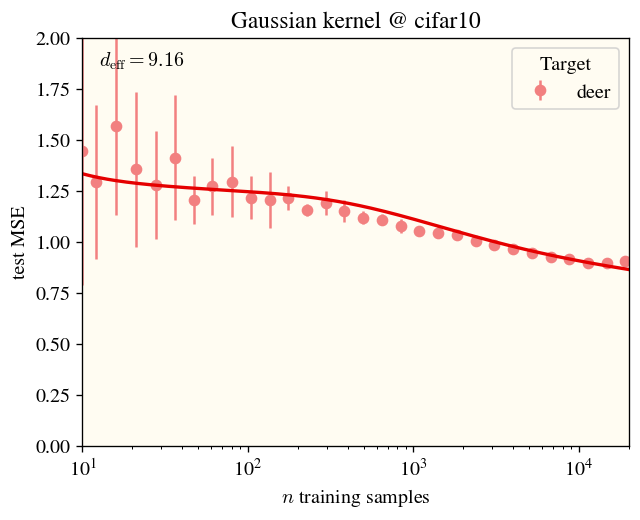

In [ ]:
fig, ax = plt.subplots(figsize=(5.5, 4.5))

xmin, xmax = 10, 2e4
TrK = 1.0
ntrains_dense = np.logspace(np.log10(xmin), np.log10(xmax), 200)
eigvals = hehe_eigvals
hehe_ridge = ridge + max(0, TrK - eigvals.sum())

for i, target in enumerate([4]):
    ystar = targets[target]
    yhat = et_yhat[:, :, target].squeeze()
    mse = ((yhat - ystar[-ntest:])**2).mean(axis=-1)
    lrn_curve_emp, lrn_curve_emp_std = mse.mean(axis=0), mse.std(axis=0)
    ax.errorbar(ntrains, lrn_curve_emp, yerr=lrn_curve_emp_std, color=lighten(colors[i], 0.5),
                ls='none', marker='o', zorder=-4, label=f"{cifar10_labels[target]}")

    coeffs = grf_coeffs[target] * H_norm
    noise_var = 1 - np.linalg.norm(coeffs)**2
    el_hehe = lambda n: eigenlearning(n, eigvals, coeffs, ridge=hehe_ridge, noise_var=noise_var)
    mse_el_hehe = np.array([el_hehe(n)["test_mse"] for n in ntrains_dense])
    ax.plot(ntrains_dense, mse_el_hehe, color=colors[i], lw=2)

kname = "Gaussian" if KERNEL_TYPE == GaussianKernel else "Laplace"
ax.set_title(f"{kname} kernel @ {DATASET}", fontsize=14)

ax.text(0.03, 0.97, f"$d_\\mathrm{{eff}} = {d_eff:.2f}$", ha="left", va="top", transform=ax.transAxes)
ax.set_xlabel(f"$n$ training samples")
ax.set_ylabel("test MSE")

ax.set_xscale("log")
ax.set_xlim(xmin, xmax)
ax.set_ylim(0, 2)
# ax.set_ylim(1e-2, 2)
# ax.set_yscale("log")
ax.legend(title="Target", ncol=2)
plt.tight_layout()
plt.show()

# Real targets (old)

In [3]:
expt_id = 3
EXPT_NAME = "hehe-eigenlearning"
KERNEL_WIDTH = 10
N_SAMPLES = 26_000
P_MODES = 100_000
DATA_DIM = 200
TARGET = "original"

if expt_id in [1, 2]:
    DATASET = "gaussian"
elif expt_id in [3, 4]:
    DATASET = "cifar10"
elif expt_id in [5, 6]:
    DATASET = "svhn"
if expt_id % 2 == 1:
    KERNEL_TYPE = GaussianKernel
else:
    KERNEL_TYPE = LaplaceKernel

if KERNEL_TYPE == GaussianKernel:
    DATA_EIGVAL_EXP = 3.0   # d_eff = 7
    ZCA_STRENGTH = 0        # d_eff = 7 ch10
    if DATASET == "svhn":
        ZCA_STRENGTH = 5e-3 # d_eff = 9
if KERNEL_TYPE == LaplaceKernel:
    DATA_EIGVAL_EXP = 1.6   # d_eff = 27
    ZCA_STRENGTH = 1e-2     # d_eff = 14 cf10

datapath = os.getenv("DATASETPATH")
exptpath = os.getenv("EXPTPATH")
if datapath is None:
    raise ValueError("must set $DATASETPATH environment variable")
if exptpath is None:
    raise ValueError("must set $EXPTPATH environment variable")
fp = f"{KERNEL_TYPE.__name__}-kw:{KERNEL_WIDTH}-target:{TARGET}-zca:{ZCA_STRENGTH}"
expt_dir = os.path.join(exptpath, "phlab", EXPT_NAME, DATASET, fp)

if not os.path.exists(expt_dir):
    assert False, f"Experiment directory {expt_dir} does not exist"
expt_fm = FileManager(expt_dir)


In [7]:
result = expt_fm.load("result.pickle")
monomials = result["monomials"]
d_eff = result["d_eff"]
print(f"d_eff = {d_eff:.2f}")
ridge = result["ridge"]
et_yhat = ExptTrace.deserialize(result["y_hat"])

emp_eigvals = result["emp_eigvals"]
hehe_eigvals = result["th_eigvals"]
iso_eigvals = result["iso_eigvals"]

targets = expt_fm.load("targets.pickle")
assert len(targets) == 1
target = list(targets.keys())[0]
ystar = targets[target]

emp_eigvecs = expt_fm.load("emp_eigvecs.npy")
H = expt_fm.load("H.npy") * np.sqrt(N_SAMPLES)

ntest = result["n_test"]
ntrains = et_yhat.get_axis("ntrain")
trials = et_yhat.get_axis("trial")

d_eff = 2.62


In [25]:
import importlib
import tools
importlib.reload(tools)
from tools import grf

In [8]:
from tools import grf

H_t = ensure_torch(H)
# H_t /= torch.linalg.norm(H_t, axis=0, keepdims=True)
# H_t *= np.sqrt(N_SAMPLES)
hehe_coeffs, uncaptured = grf(H_t, ystar, P_MODES)
del H_t

GRF: 100%|██████████| 100000/100000 [01:49<00:00, 916.67step/s, uncaptured=0.152]


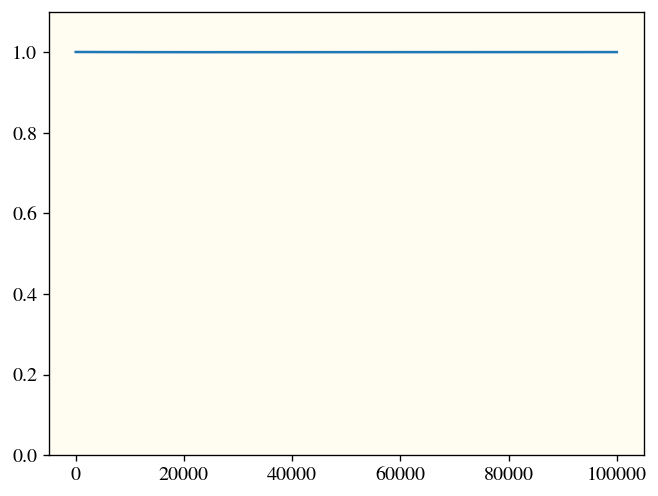

In [34]:
idxs = np.arange(len(hehe_coeffs)) + 1
plt.plot(idxs, np.cumsum(ensure_numpy(hehe_coeffs**2)) + uncaptured)
plt.ylim(0, 1.1)
plt.show()

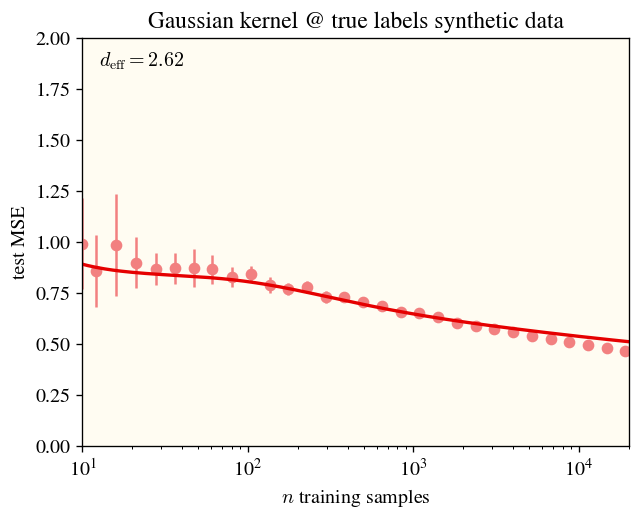

In [ ]:
fig, ax = plt.subplots(figsize=(5.5, 4.5))

xmin, xmax = 10, 2e4
TrK = 1.0
use_hehe_coeffs = True
use_ots_correction = False
ntrains_dense = np.logspace(np.log10(xmin), np.log10(xmax), 200)

yhat = et_yhat[:, :, target].squeeze()
mse = ((yhat - ystar[-ntest:])**2).mean(axis=-1)
lrn_curve_emp, lrn_curve_emp_std = mse.mean(axis=0), mse.std(axis=0)
ax.errorbar(ntrains, lrn_curve_emp, yerr=lrn_curve_emp_std, color=lighten(colors[0], 0.5),
            ls='none', marker='o', zorder=-4, label=f"{target}")

eigvals = hehe_eigvals
if use_hehe_coeffs:
    coeffs = ensure_numpy(hehe_coeffs, clone=True)
    noise_var = 1 - np.linalg.norm(coeffs)**2 # uncaptured[-1].item()**2
else:
    coeffs = emp_eigvecs.T @ ystar
    coeffs /= np.linalg.norm(coeffs)
    noise_var = 0
hehe_ridge = ridge + max(0, TrK - eigvals.sum())
el_hehe = lambda n: eigenlearning(n, eigvals, coeffs, ridge=hehe_ridge, noise_var=noise_var)
mse_el_hehe = np.array([el_hehe(n)["test_mse"] for n in ntrains_dense])
if use_ots_correction:
    train_mse = np.array([el_hehe(n)["train_mse"] for n in ntrains_dense])
    mse_el_hehe = (N_SAMPLES*mse_el_hehe - train_mse*ntrains_dense) / (N_SAMPLES - ntrains_dense)
ax.plot(ntrains_dense, mse_el_hehe, color=colors[0], lw=2)

kname = "Gaussian" if KERNEL_TYPE == GaussianKernel else "Laplace"
dataname = "CIFAR10" if DATASET == "cifar10" else "synthetic data"
omniscient = "" if use_hehe_coeffs else " (omniscient)"
ax.set_title(f"{kname} kernel @ true labels {dataname}{omniscient}", fontsize=14)

ax.text(0.03, 0.97, f"$d_\\mathrm{{eff}} = {d_eff:.2f}$", ha="left", va="top", transform=ax.transAxes)
ax.set_xlabel(f"$n$ training samples")
ax.set_ylabel("test MSE")

ax.set_xscale("log")
ax.set_xlim(xmin, xmax)
ax.set_ylim(0, 2)
# ax.set_ylim(1e-2, 2)
# ax.set_yscale("log")
# ax.legend(title="Target source exponent", ncol=2)
plt.tight_layout()
plt.show()

In [23]:
hehe_coeffs

tensor([ 2.6047e-01, -4.0108e+01,  4.3538e+01,  ...,  1.1571e-02,
        -4.8451e-02, -2.7661e-02], device='cuda:0')